This notebook consists of an exploratory data analysis for the normal data available in the 3W Dataset. For more details about the dataset, check [VARGAS et al. (2019)](https://linkinghub.elsevier.com/retrieve/pii/S0920410519306357). For more in-depth exploratory analysis of the 3W Dataset and others process systems engineering datasets, check [MELO et al. (2022)](https://www.sciencedirect.com/science/article/abs/pii/S0098135422003003).

In [1]:
import os
import copy
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

## Reference table of variables

In [2]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC', 
         'P-JUS-CKGL':'Pa', 'T-JUS-CKGL':'degC',
         'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         'Temperature downstream of the GLCK',
         'Gas lift flow rate']

reference_table = pd.DataFrame(index=np.arange(1,len(names)+1))
reference_table.index.name='Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()
reference_table

,Tag,Name,Unit
Number,,,
1,P-PDG,Pressure at the PDG,Pa
2,P-TPT,Pressure at the TPT,Pa
3,T-TPT,Temperature at the TPT,degC
4,P-MON-CKP,Pressure upstream of the PCK,Pa
5,T-JUS-CKP,Temperature downstream of the PCK,degC
6,P-JUS-CKGL,Pressure downstream of the GLCK,Pa
7,T-JUS-CKGL,Temperature downstream of the GLCK,degC
8,QGL,Gas lift flow rate,sm^3/s


In [3]:
plt.rc('font', family='serif', size=12) # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

## Data importing

In [4]:
%%time

EVENT = 0

PATH = os.path.join('..', '..', 'dataset', str(EVENT))

if os.path.exists(PATH):
    files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]

dfs = {}

for file in files:
    
    dfs[file[:-4]] = pd.read_csv(os.path.join(PATH, file), index_col = 0,
                     parse_dates = True).rename_axis(None)
    
print('Data read!\nNumber of instances: ',len(dfs))

Data read!
Number of instances:  594
CPU times: user 13.6 s, sys: 2.5 s, total: 16.1 s
Wall time: 16.7 s


## Instances and time periods

According to the definition of the 3W Dataset's authors, instances are blocks corresponding to specific time intervals. The dataset contains 1984 instances, of which 597 are normal.

The next cell stores the beginnings of instances and the beginnings of *periods*, defined here as contiguous sets of instances.

In [5]:
instance_beginnings = sorted(dfs.keys())

index_beginnings_new_period = {1: [0,7,17,19,24,64,68], 
                               2: [94,99,102,153,169,183,261],
                               3: [304,308,309,318,322],
                               4: [330],
                               5: [342,361,368,411,417],
                               6: [423,439,453,473],
                               7: [538],
                               8: [540,561,579,594]}#final: 596

## Visualization functions

The following functions help us to obtain time series and scatter plots for this dataset.

In [6]:
def plot_tag (tag, sampling=60):
    
    #https://stackoverflow.com/a/7513401/
    hsv = plt.get_cmap('Paired')
    colors = hsv(np.linspace(0, 1, 8))

    fig, ax = plt.subplots(figsize=(15,10))

    for key in dfs:
        well = int(key[8:10])
        ax.plot(dfs[key][tag][::60].values, color=colors[well-1],label=f'Well {well}',ls='',marker='.')
        ax.axhline(dfs[key][tag][::60].values.mean(),color=colors[well-1],ls='--',marker='')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    desired_order_list = [f'Well {i}' for i in range(1,9)]
    reordered_dict = {k: by_label[k] for k in desired_order_list}
    ax.legend(reordered_dict.values(), reordered_dict.keys(), prop={'size': 20},markerscale=5)
    ax.set_ylabel(tags[tag])
    ax.set_title(tag);

In [7]:
def scatterplot (data, columns, ax, spines = False, px = 5, n = None):
    
    if n is None:
        n = data.shape[1]
    for i in range(n):
        for j in range(n):
            if i <= j:
                ax[i,j].set_visible(False)
            else:
                cvs = ds.Canvas()
                agg = cvs.points(data, columns.iloc[i], columns.iloc[j])
                img = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg,px=px), cmap=cc.fire), "white").to_pil()
                ax[i,j].imshow(img)
                if j==0:
                    ax[i,j].set_ylabel(i+1)
                if i==n-1:
                    ax[i,j].set_xlabel(j+1)
            ax[i,j].xaxis.set_ticks([])
            ax[i,j].yaxis.set_ticks([])
            if not spines:
                ax[i,j].spines['top'].set_visible(False)
                ax[i,j].spines['right'].set_visible(False)
                ax[i,j].spines['bottom'].set_visible(False)
                ax[i,j].spines['left'].set_visible(False)

In [8]:
def plot_timeseries_well (ax, well):
    
    start_index = index_beginnings_new_period[well][0]
    if well<8:
        end_index1 = index_beginnings_new_period[well+1][0]
        end_index2 = end_index1
    else:
        end_index1 = None
        end_index2 = 597
    data = pd.concat([dfs[key] for key in instance_beginnings[start_index:end_index1]]).drop_duplicates()     
    for i in range(8):
        ax[i].plot(data.iloc[:,i].values,c='k',linewidth=0.8)
        for j in range(start_index,end_index2):
            loc = data.index.get_loc(dfs[instance_beginnings[j]].index[0])
            ax[i].axvline(loc,ls='--',linewidth=0.6)
        for j in index_beginnings_new_period[well]:
            loc = data.index.get_loc(dfs[instance_beginnings[j]].index[0])
            ax[i].axvline(loc,c='r',linewidth=2)
        ax[i].set_ylabel(i+1,rotation=0,fontsize=14)
        ax[i].set_yticks([])
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        if i<(8-1):
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
                
    return data

In [9]:
def plot_periods(well, period, yticks=False):
    
    #which_indexes_to_plot = index_beginnings_new_period[well][time_period_pos]
    
    period -=1
    
    fig = plt.figure(constrained_layout=True, figsize=(16, 6))
    subfigs = fig.subfigures(1, 2, wspace=0.03)
    ax1 = subfigs[0].subplots(8, 1, sharex=True)
    
    if (period+1) != len(index_beginnings_new_period[well]):
        slicezao = slice(index_beginnings_new_period[well][period],
                         index_beginnings_new_period[well][period+1])
    else:
        if well != 8:
            slicezao = slice(index_beginnings_new_period[well][period],
                             index_beginnings_new_period[well+1][0])
        else:
            slicezao = slice(index_beginnings_new_period[well][period],-1)
            
    n_instances = len(instance_beginnings[slicezao])

    df_plot = pd.concat([dfs[key] for key in instance_beginnings[slicezao]]).drop_duplicates()

    for i in range(8):
        ax1[i].plot(df_plot.index,df_plot.iloc[:,i],color='k',linewidth=0.8)
        ax1[i].set_ylabel(i+1,rotation=0,fontsize=14)
        if not yticks:
            ax1[i].set_yticks([])
        ax1[i].spines["top"].set_visible(False)
        ax1[i].spines["right"].set_visible(False)
        ax1[i].spines["left"].set_visible(False)
        if i<(8-1):
            ax1[i].set_xticks([])
            ax1[i].spines["bottom"].set_visible(False)
            ax1[i].xaxis.set_ticks_position('none')
        else:
            for label in ax1[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

    ax2 = subfigs[1].subplots(8,8)

    for k in range(2):
        scatterplot(data = df_plot.iloc[:,:8], 
                    columns = reference_table['Tag'],
                    ax = ax2,
                    spines = False)
        
    df_count_valid_variables = copy.deepcopy(df_plot.iloc[:,:8])   
    df_count_valid_variables.columns = np.arange(1,9)
    df_count_valid_variables = df_count_valid_variables.loc[:, df_count_valid_variables.var(ddof=1) > 1e-6]
        
    table_periods.loc[f'W{well}P{period+1}',:] = np.array([df_plot.index[0],
                                                         df_plot.index[-1],
                                                         list(df_count_valid_variables.columns),n_instances],
                                                        dtype='object')
        
    return df_plot

In [10]:
table_periods = pd.DataFrame(columns=['Start','End','Variables','No. of instances'])
table_periods.index.name = 'ID'

## Visualization

### Time series plots

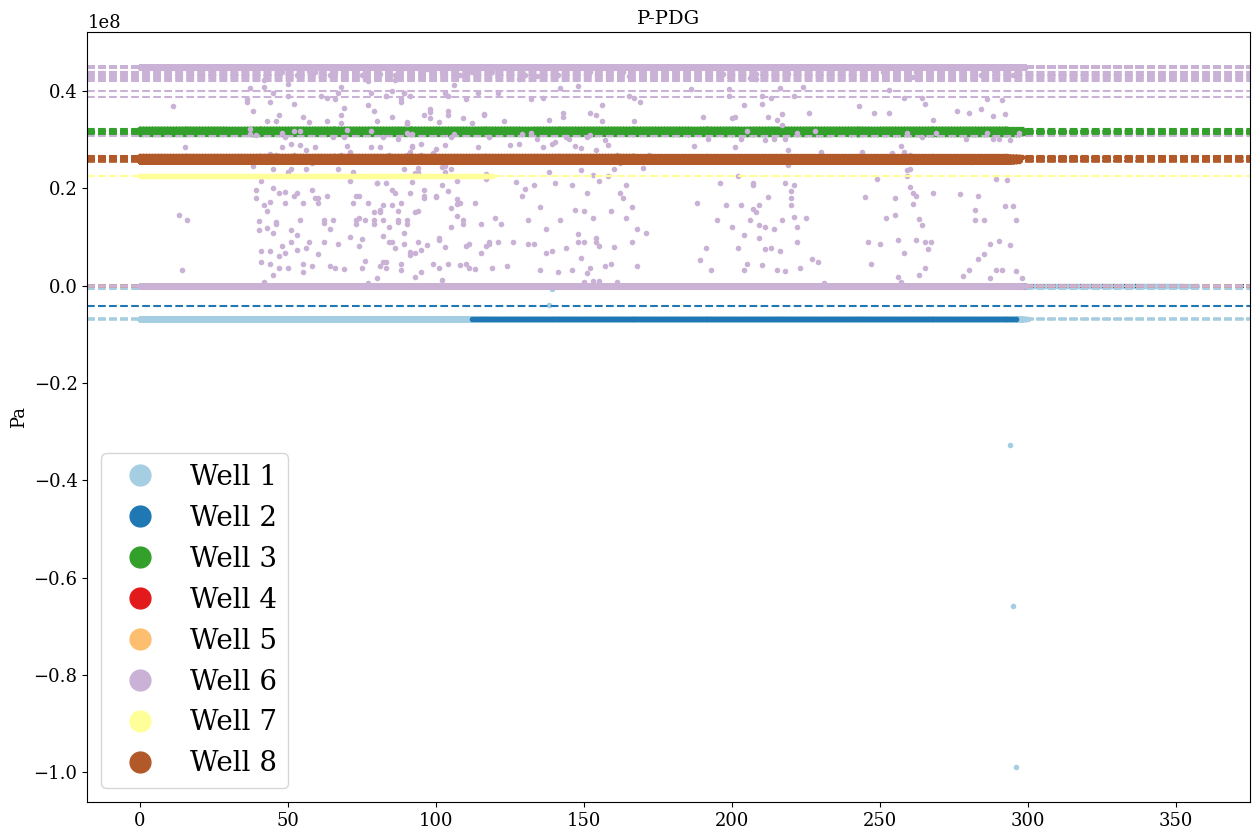

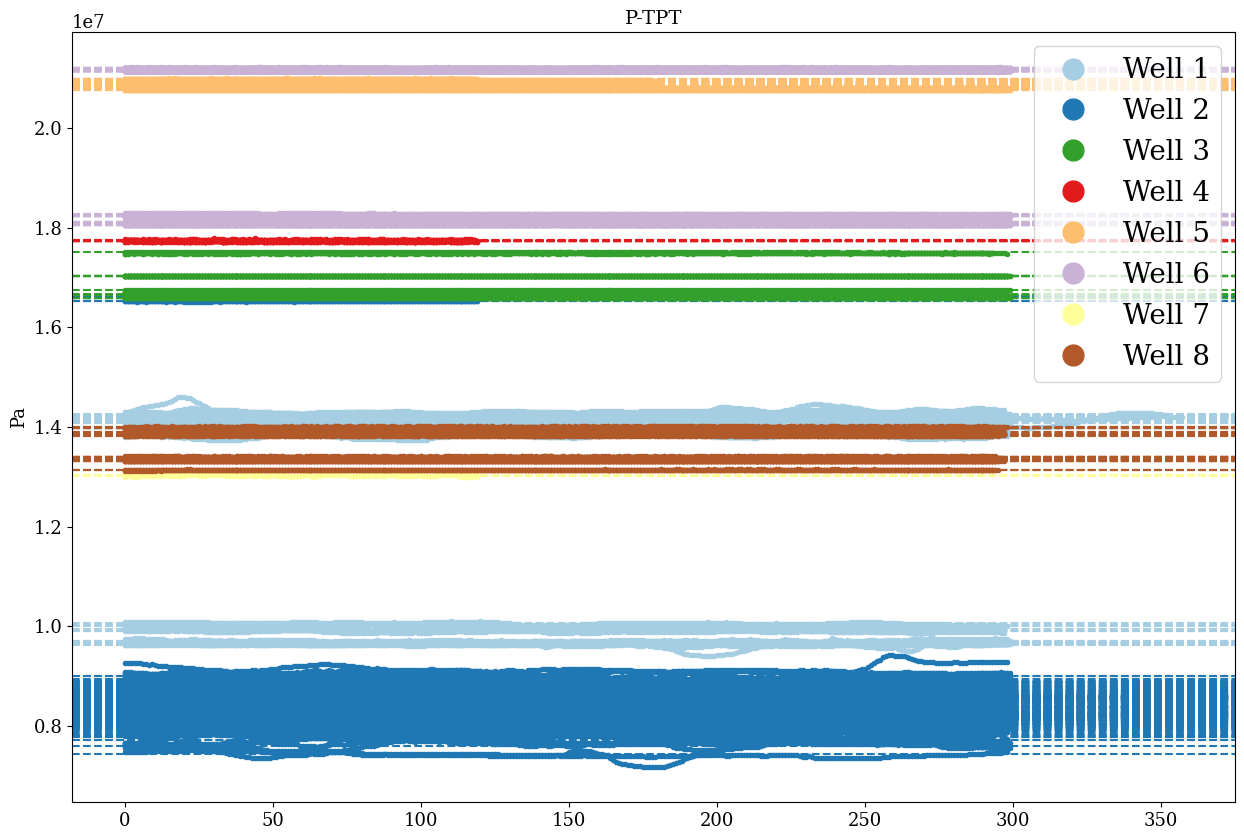

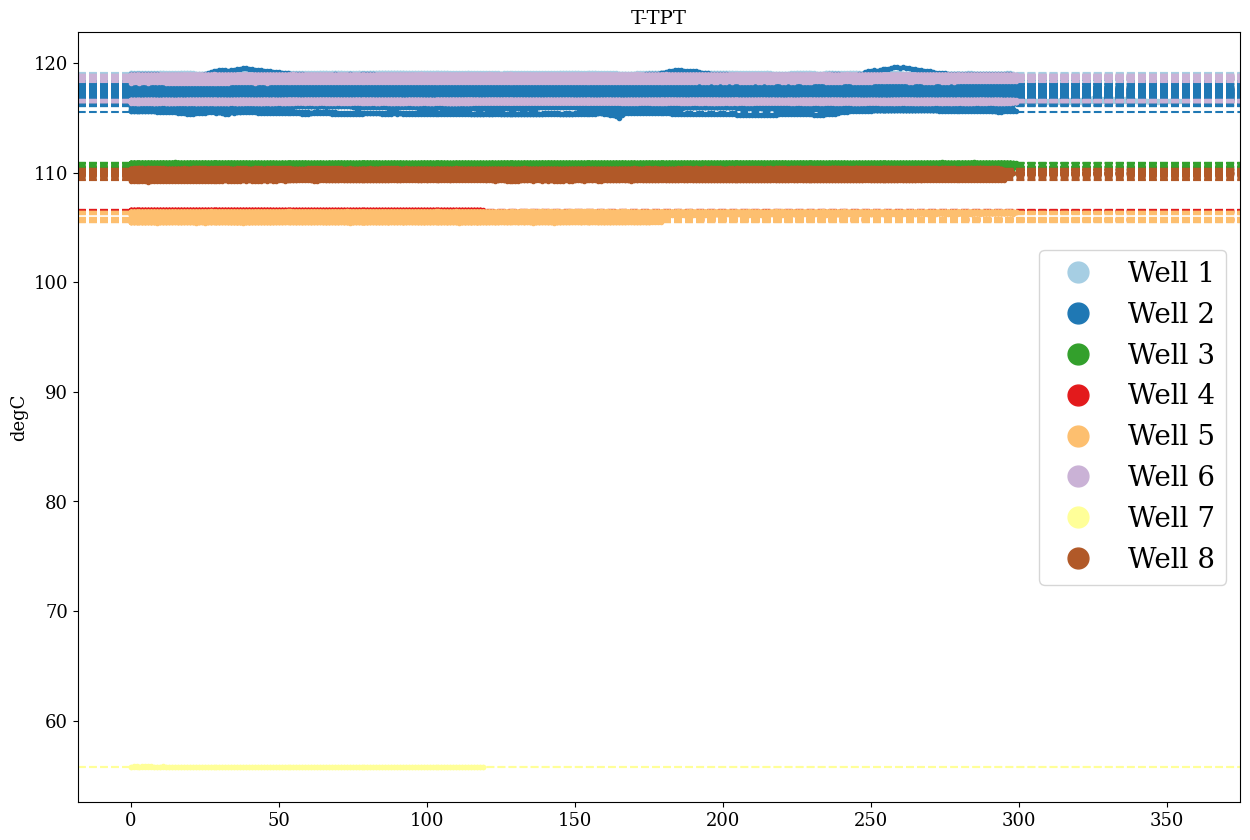

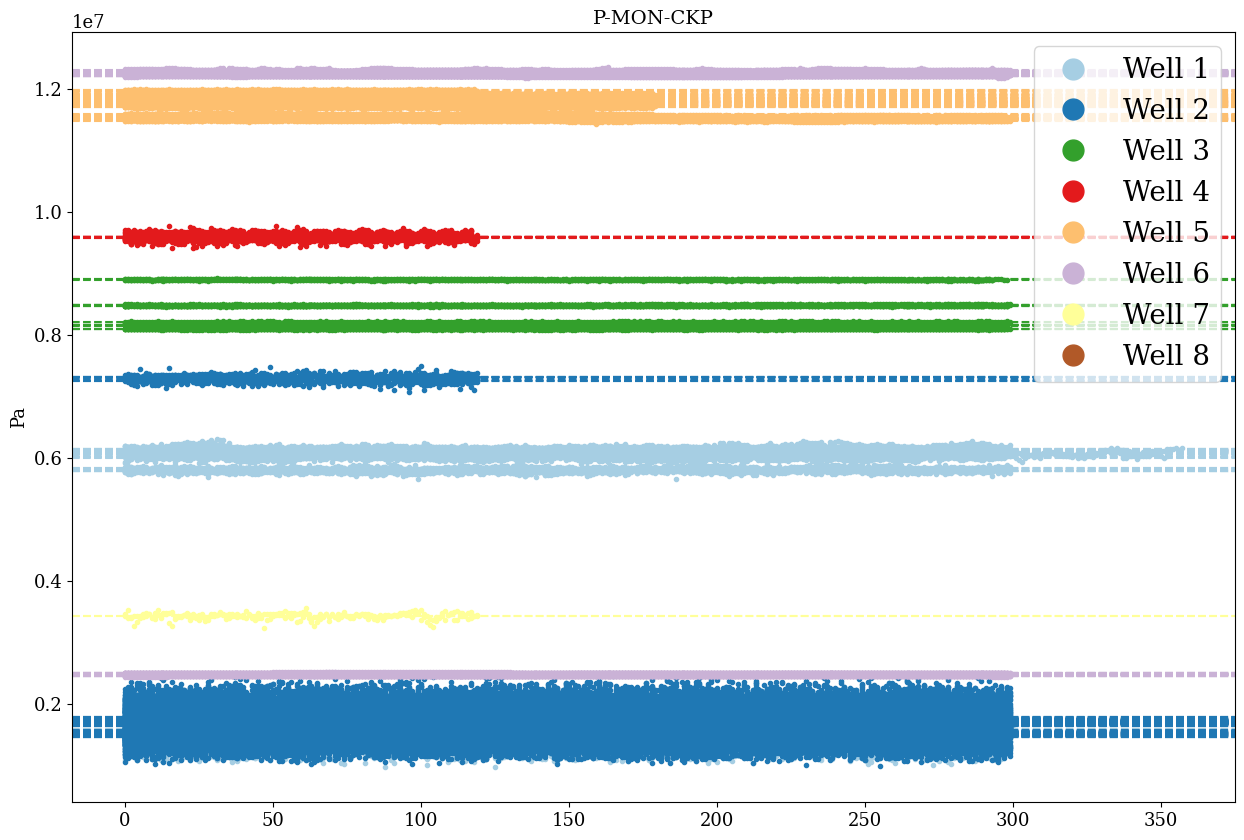

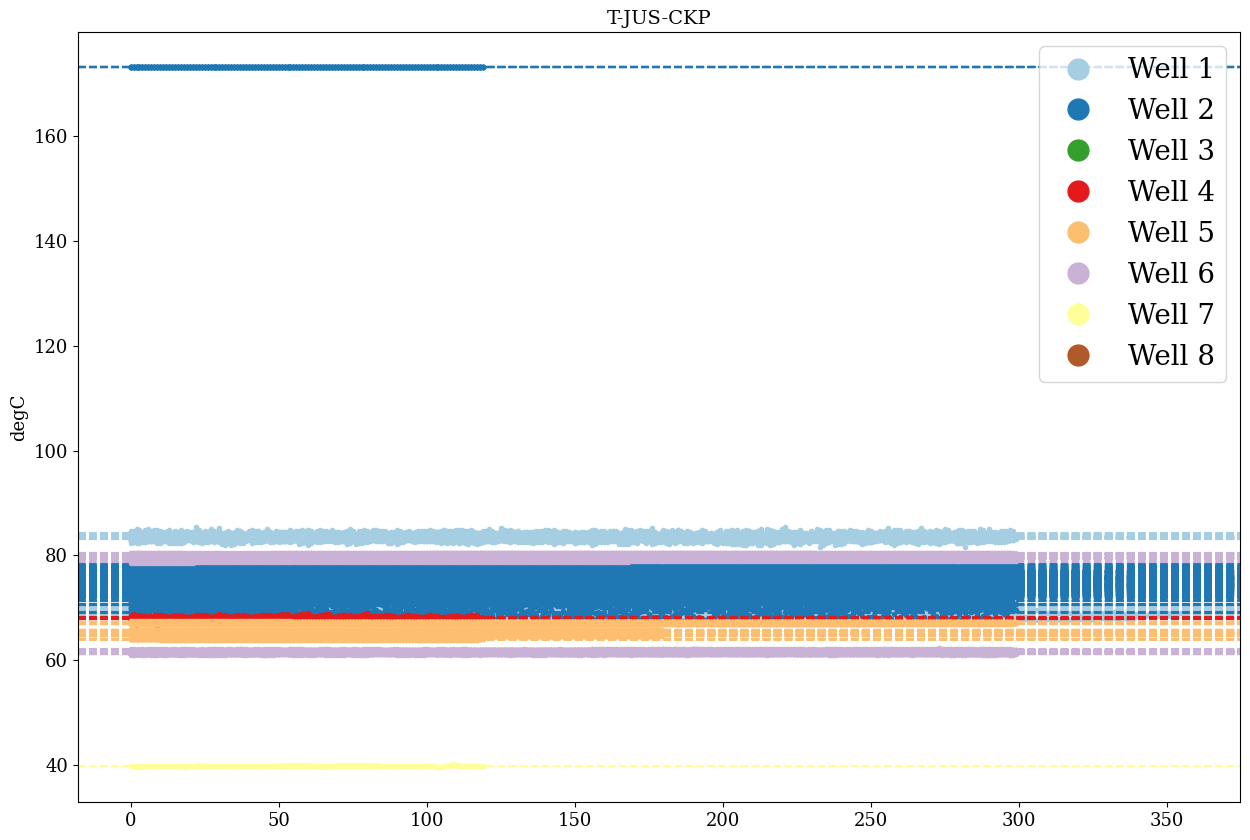

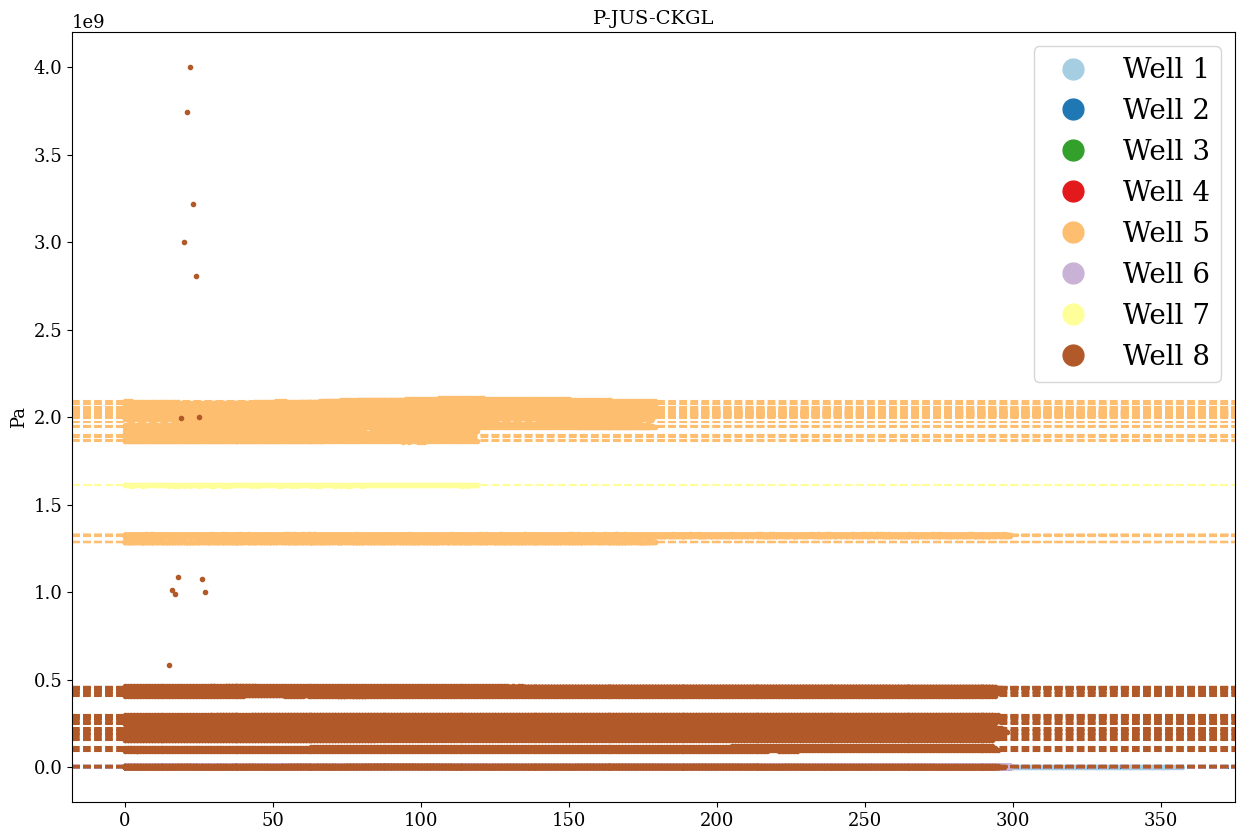

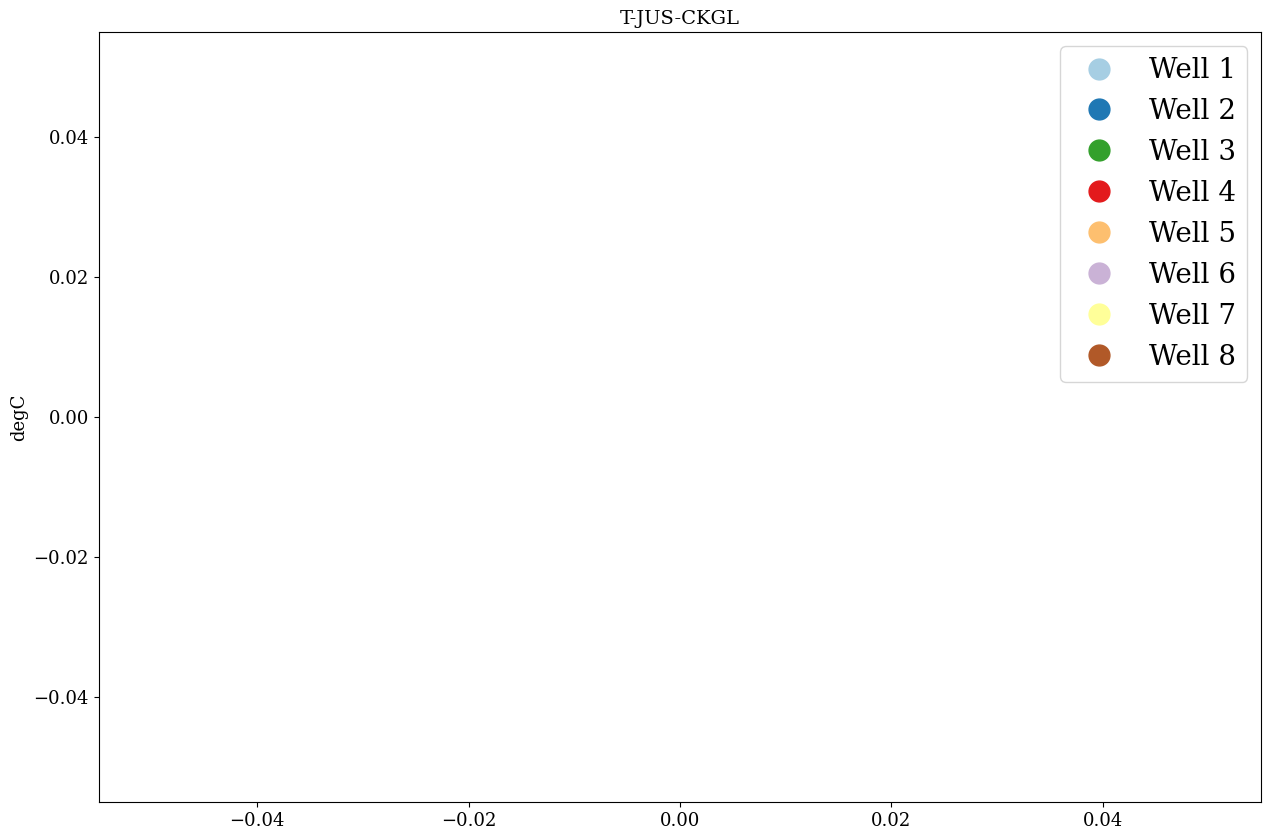

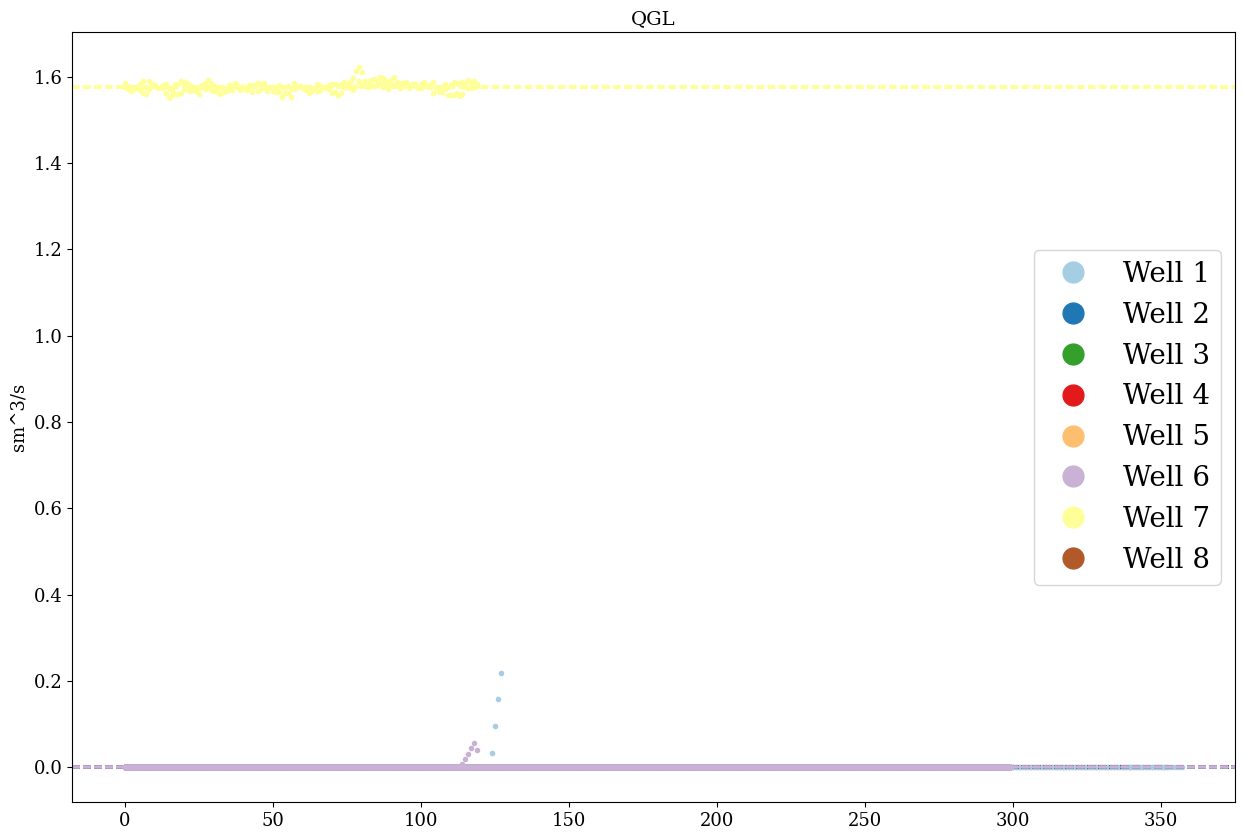

In [11]:
for tag in reference_table.Tag:
    plot_tag(tag)

### Missing data patterns

CPU times: user 33.9 s, sys: 16.3 s, total: 50.3 s
Wall time: 24.5 s


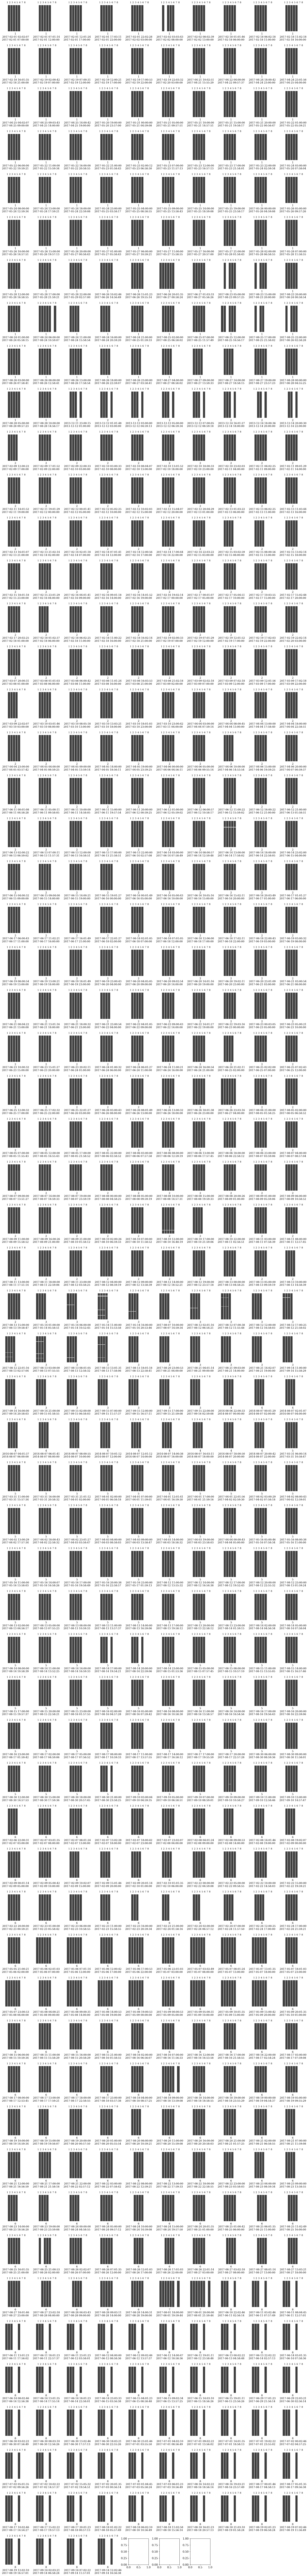

In [12]:
%%time

fig, ax = plt.subplots(60,10, figsize=(20,170))

i=0

for key in sorted(dfs.keys(), key=lambda x:x.lower()):
    well = int(key[8:10])
    df_test = copy.deepcopy(dfs[key])
    if 'class' in df_test.columns:
        del df_test['class']
    df_test.columns = np.arange(1,9)
    df_test.loc[:,(df_test.var(ddof=1) < 1e-6)] = np.nan
    missingno.matrix(df_test,sparkline=False,ax=ax.ravel()[i])
    ax.ravel()[i].set_yticks([])
    ax.ravel()[i].xaxis.set_tick_params(labelsize=11,rotation=0)
    ax.ravel()[i].set_title(f'{well}\n {df_test.index[0]}\n{df_test.index[-1]}',y=-0.4,fontdict={'fontsize': 12})
    i+=1
    del df_test

for i in [-3,-2,-1]:
    ax.ravel()[i].axis('off')

fig.tight_layout()

## Time period analysis

In the following time series charts, instances are separated by blue dashed lines and time periods are separated by thick red lines.

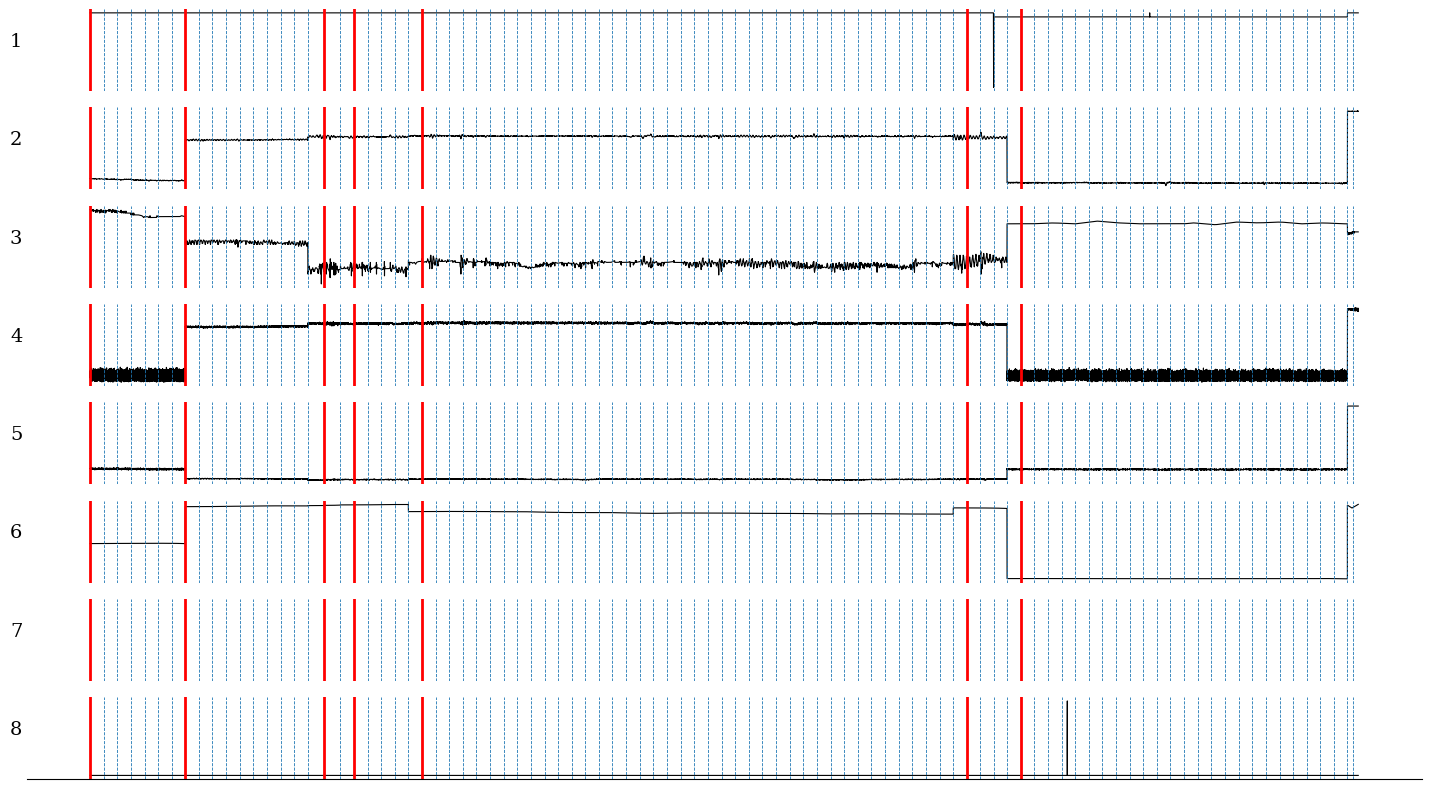

In [13]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 1)

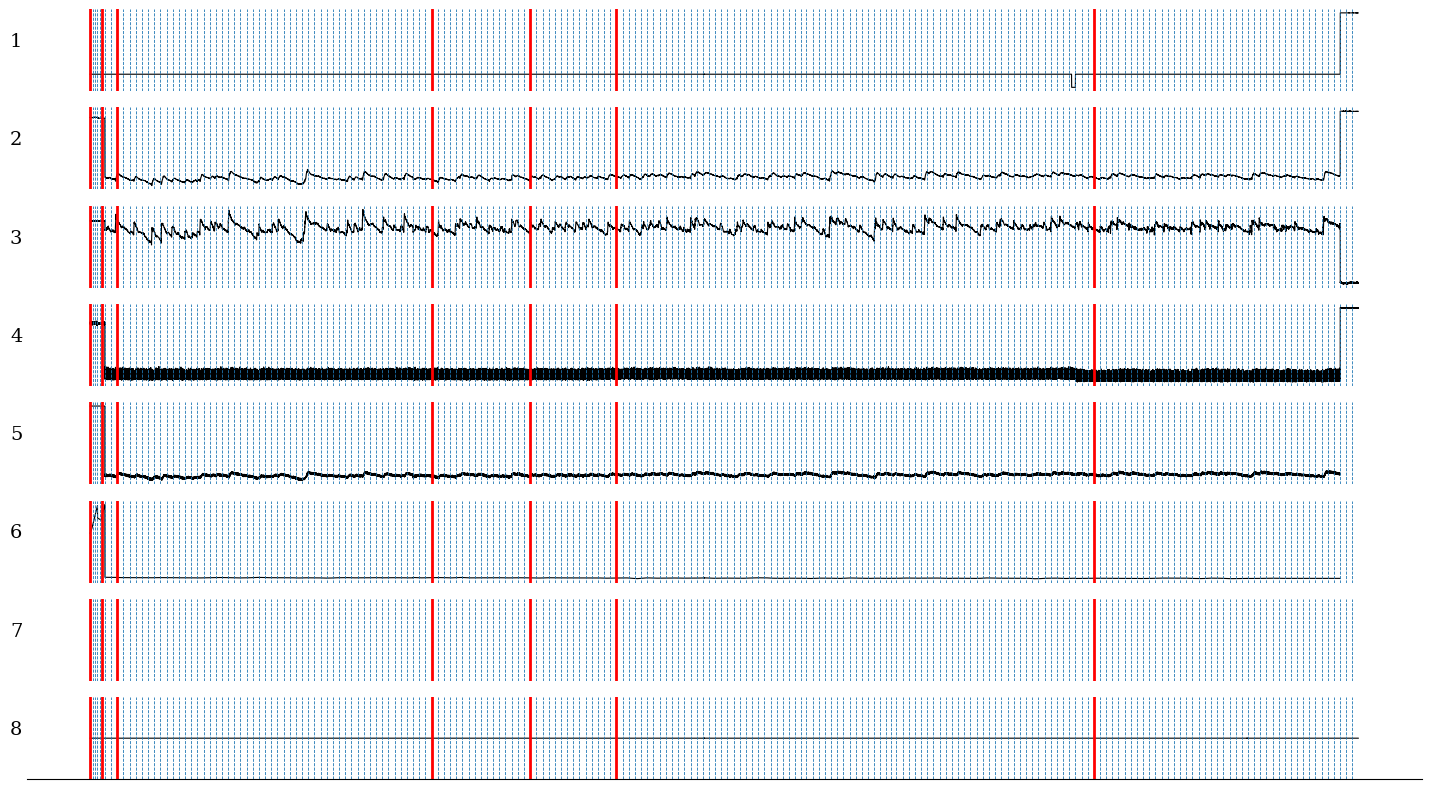

In [14]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 2)

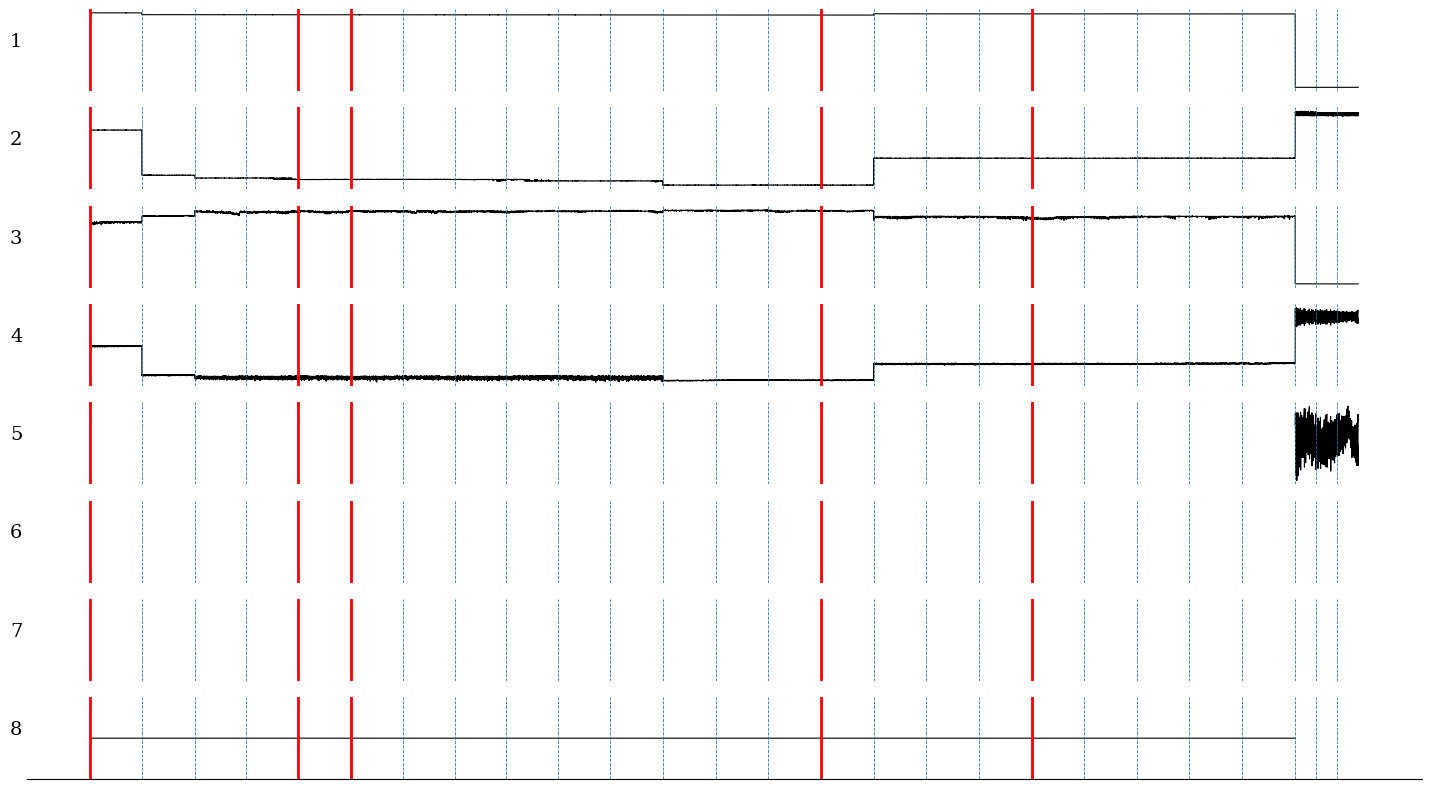

In [15]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 3)

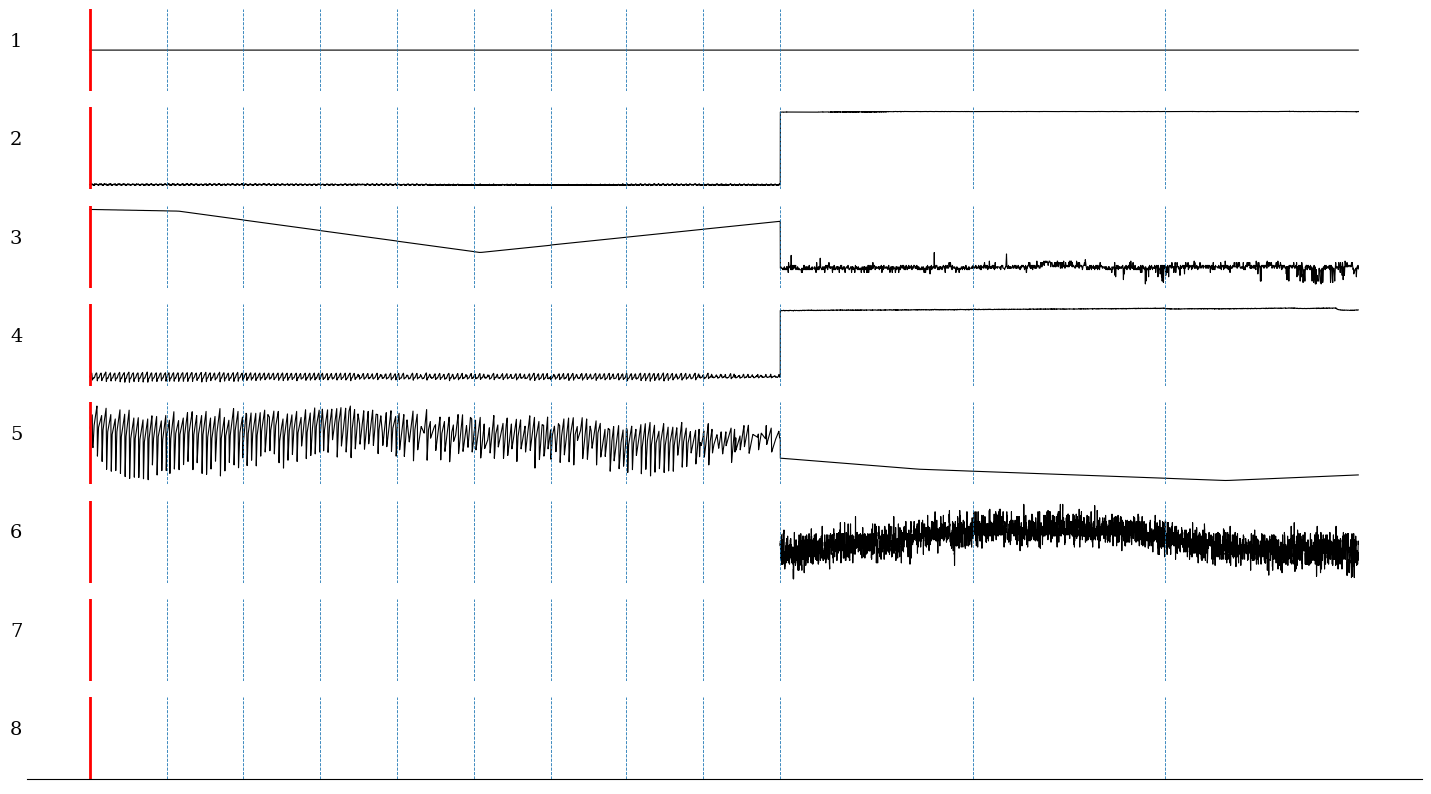

In [16]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 4)

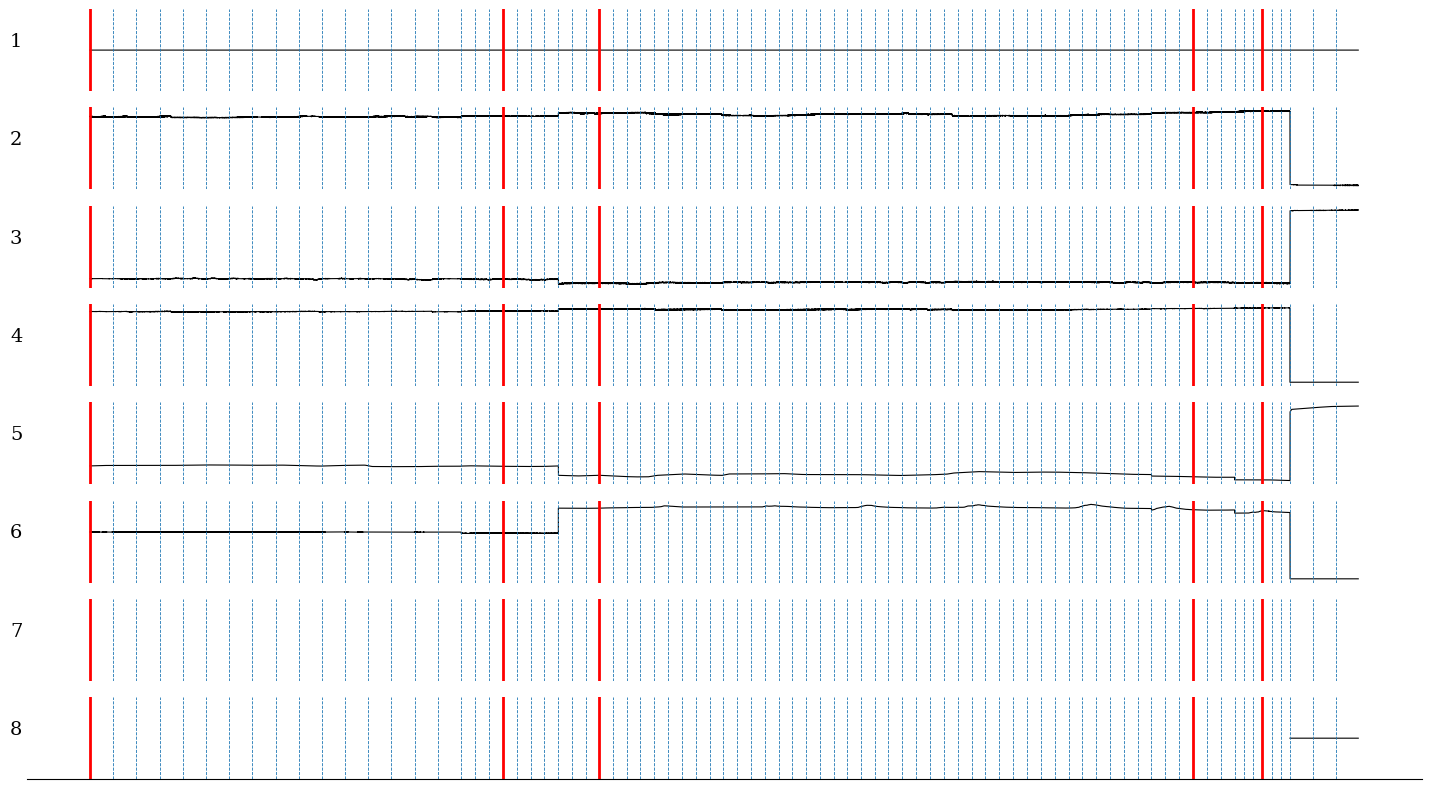

In [17]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 5)

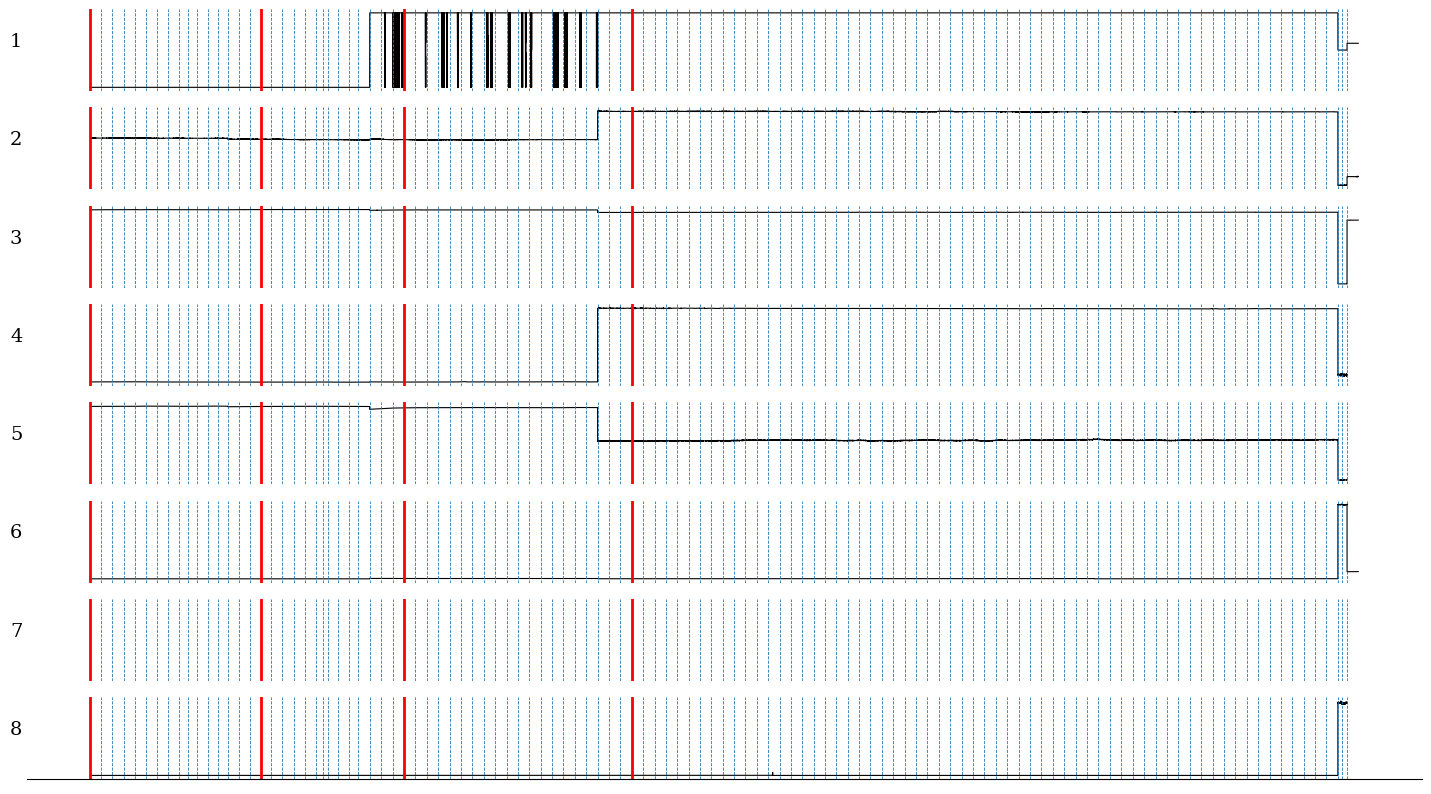

In [18]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 6)

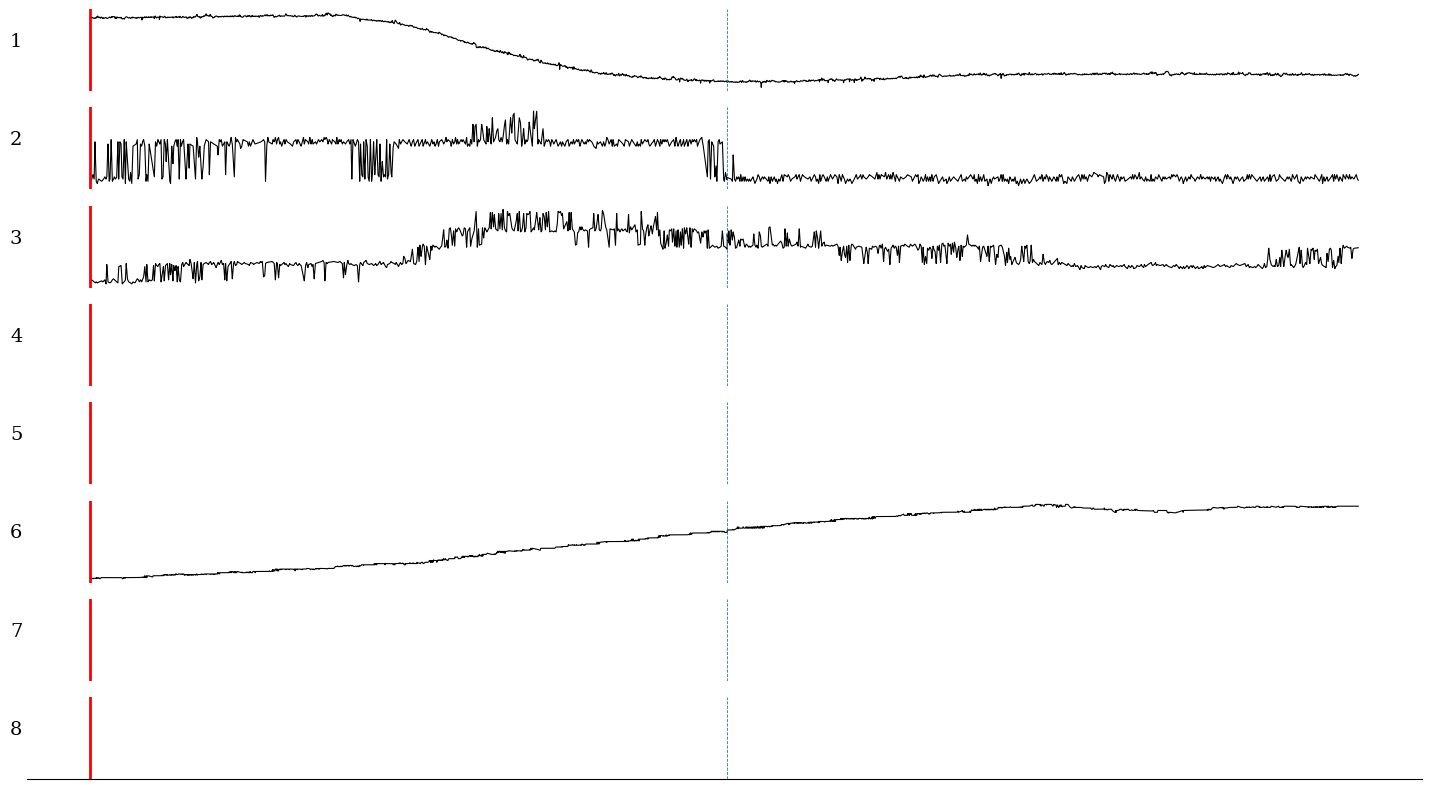

In [19]:
fig, ax = plt.subplots(8, 1, figsize=(18, 10),sharex=True)

data_well1 = plot_timeseries_well (ax = ax,  well = 7)